# Apresentação

- PSR maintenance model
    - Formulação
    - Implementação
    - Comparação com nosso modelo de combinação convexa
    - Caso com dados reais
- Probabilidade de falha
    - Soma de variáveis aleatórias
    - Implementação para 2 usinas
    - Implementação para n usinas
    - Método de Monte Carlo
    - Restrição de manutenção e vários estágios

In [1]:
using Xpress, JuMP
using CSV

┌ Info: Xpress: Found license file xpauth.xpr
└ @ Xpress C:\Users\lucasresck\.julia\packages\Xpress\Jdi4R\src\xprs_userlic.jl:43
┌ Info: Xpress: User license detected.
└ @ Xpress C:\Users\lucasresck\.julia\packages\Xpress\Jdi4R\src\xprs_userlic.jl:98
┌ Info: Xpress-MP licensed by Fair Isaac Corporation to PSR for PSR applications
└ @ Xpress C:\Users\lucasresck\.julia\packages\Xpress\Jdi4R\src\xprs_userlic.jl:99


In [87]:
include("..\\..\\Functions\\dados_e_plot.jl")
include("..\\..\\Functions\\comparison.jl");

In [3]:
# Capacidade de cada usina
G = [10,5,20,18,23,32,7,12,10,20,17,32,12,13,17];
# Demanda de cada mês
d = [238,220,187,175,135,127,144,165,193,205,213,233];
#θ piores casos
θ = 0.3
#Número de cenários
Ns = 10;

# PSR maintenance scheduling model

$$max\ \ \lambda \cdot CVaR_\beta + (1 - \lambda) \dfrac{1}{N_S} \sum_s \delta_s$$
$$s.a.\ \ \delta_s \leq \dfrac{1}{d^t} \left(\sum_h \overline{g}_h (1 - \alpha_h^t) - d_s^t\right),\ \  \forall t, s$$
$$CVaR_\beta = z + \dfrac{1}{N_S} \dfrac{1}{1 - \beta} \sum_s \mu_s$$
$$\mu_s + z \leq \delta_s, \ \ \forall s$$
$$\mu_s \leq 0, \ \ \forall s$$
    $$\sum_t (1 - \alpha_h^t) = N_t - k, \ \ \forall h$$

In [4]:
#Quantidade de cenários
S = Ns;
#Capacidade de renováveis
R = rand(1:100, 12, S);
dl = d;
for i in 2:S
    dl = hcat(dl, d)
end
#demanda líquida
dl = dl - R;

In [5]:
N_t1 = 12
g_h1 = G
N_S1 = 10
r1 = zeros(1, N_S1, N_t1)
dt1 = d
d_s1 = dl'
β1 = 0.2
λ1 = 0.0
k1 = 1;

In [6]:
m1 = Model(solver = Xpress.XpressSolver(OUTPUTLOG = 1))

@variables m1 begin
    α_h[1:length(g_h1), 1:N_t1], Bin
    δ_s[1:N_S1]
    z
    μ_s[1:N_S1] <= 0
end

@constraintref reserve[1:N_t1, 1:N_S1]
for t in 1:N_t1
    for s in 1:N_S1
        reserve[t, s] = @constraint(m1, δ_s[s]
            <= 1 / dt1[t] * (sum(g_h1[h] * (1 - α_h[h, t]) for h in 1:length(g_h1)) - d_s1[s, t]))
    end
end

@constraintref CVaR[1:N_S1]
for s in 1:N_S1
    CVaR[s] = @constraint(m1, μ_s[s] + z <= δ_s[s])
end

@constraintref plants_h[1:length(g_h1)]
for h in 1:length(g_h1)
    plants_h[h] = @constraint(m1, sum((1 - α_h[h, t]) for t in 1:N_t1) == N_t1 - k1)
end

@expression(m1, CVaR_β, z + 1 / N_S1 * 1 / (1 - β1) * sum(μ_s))

@objective(m1, Max, λ1 * CVaR_β + (1 - λ1) * 1 / N_S1 * sum(δ_s));

In [7]:
JuMP.build(m1)
Xpress.setlogfile(m1.internalModel.inner, "../../Files/Logs/Apresentacao das tarefas (2)/m1.log")

In [8]:
@time solve(m1)
δ_s8 = getvalue(δ_s)
schedule_matrix1 = getvalue(α_h);

  0.771819 seconds (1.36 M allocations: 67.420 MiB, 4.53% gc time)


In [9]:
dados1, heatmap1, graph1 = dados_e_plot(g_h1, schedule_matrix1, d_s1', legend = true)
dados1

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],248.0
2,2,[],248.0
3,3,"[8, 11, 15]",202.0
4,4,"[3, 14]",215.0
5,5,[5],225.0
6,6,[4],230.0
7,7,[10],228.0
8,8,"[6, 9, 12, 13]",162.0
9,9,"[1, 2, 7]",226.0


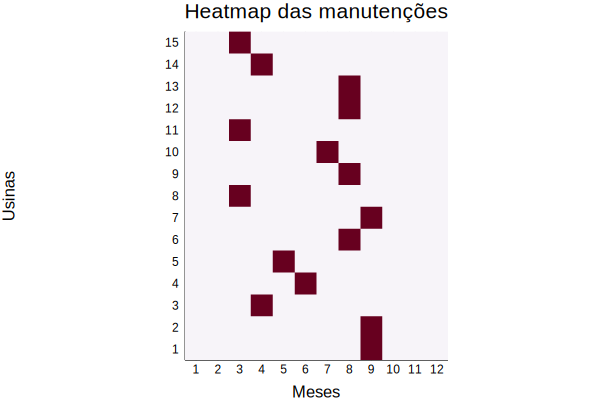

In [10]:
heatmap1

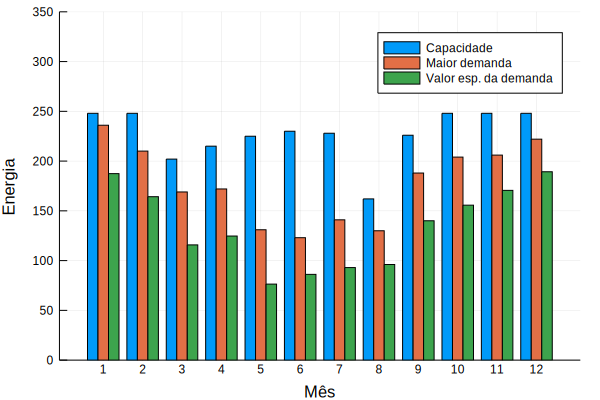

In [11]:
graph1

## Comparação com nosso modelo de combinação convexa

$$min\ \ \lambda \cdot CVar_\theta + (1-\lambda)\cdot \sum_s \alpha_s\cdot\frac{1}{N_s}$$
$$s.a.\ \ \alpha_s \geq \sum_i Gdisp_i^t-Dliq_t^s,\ \ \forall t$$
$$\sum_t x_i^t = 1,\ \ \forall i$$
$$\sum_i Gdisp_i^t \geq D_t, \ \ \forall t$$
$$Gdisp_i^t = (1-x_i^t)G^i, \ \ \forall i, t$$
$$CVar_\theta = z - \sum_s p_s \frac{\delta_s}{1-\theta}$$
$$\delta_s \leq z-\alpha_s$$
$$\delta_s \leq 0$$

In [12]:
G2 = G
d2 = dl
θ2 = θ
λ2 = 0.0

Ns2 = Ns
nplants2 = length(G2)
nmonths2 = size(d2)[1];

In [13]:
m2 = Model(solver = Xpress.XpressSolver(OUTPUTLOG = 1))

@variable(m2, x[1:nplants2, 1:nmonths2], Bin)
@variable(m2, α[1:Ns2])
@variable(m2, z)
@variable(m2, δ[1:Ns2])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m2, sum(x[plant, 1:nmonths2]) == 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths2, 1:Ns2]
for month in 1:nmonths2
    for scenario in 1:Ns2
        constraints2[month, scenario] = @constraint(m2, sum(G2 .* (1 .- x[1:nplants2, month])) >= d2[month, scenario])
    end
end

@constraintref constraints3[1:nmonths2, 1:Ns2]
for month in 1:nmonths2
    for scenario in 1:Ns2
        constraints3[month, scenario] = @constraint(m2, α[scenario] >= sum(G2 .* (1 .- x[1:nplants2, month])) - d2[month, scenario])
    end
end

@constraintref constraints4[1:Ns2]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m2, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns2]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m2, δ[scenario] <= 0)
end

@expression(m2, CVaR, z - sum(1 / Ns2 * δ[scenario] / (1 - θ2) for scenario in 1:Ns2))
@expression(m2, Eα, sum(α) / Ns2)

@objective(m2, Min, λ2 * CVaR + (1 - λ2) * Eα);

In [14]:
JuMP.build(m2)
Xpress.setlogfile(m2.internalModel.inner,"../../Files/Logs/Apresentacao das tarefas (2)/m2.log")

In [15]:
@time solve(m2)
schedule_matrix2 = getvalue(x);

 15.591539 seconds (90 allocations: 56.883 KiB)


In [16]:
dados2, heatmap2, graph2 = dados_e_plot(G, schedule_matrix2, dl, legend = true)
dados2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],248.0
2,2,[],248.0
3,3,"[1, 13]",226.0
4,4,[10],228.0
5,5,"[2, 4, 5, 14]",189.0
6,6,"[9, 11, 12]",189.0
7,7,"[3, 8, 15]",199.0
8,8,"[6, 7]",209.0
9,9,[],248.0


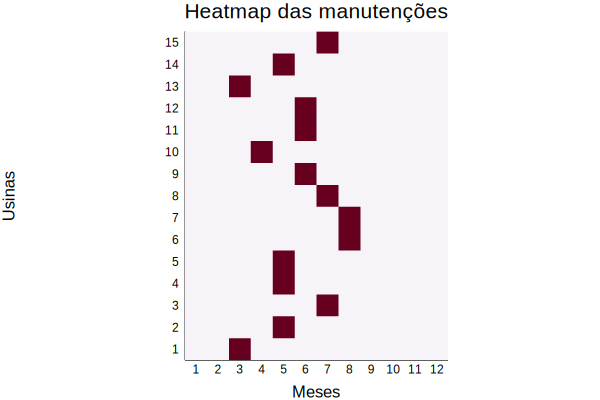

In [17]:
heatmap2

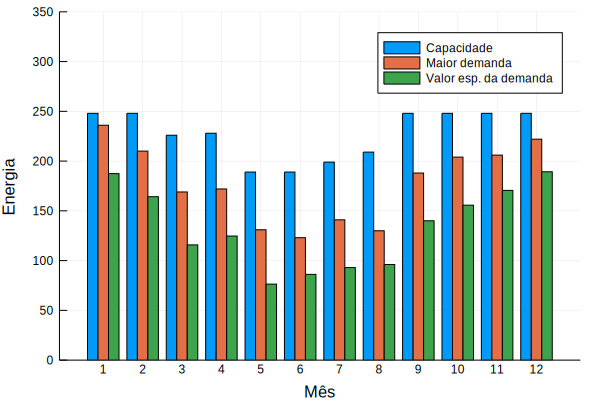

In [18]:
graph2

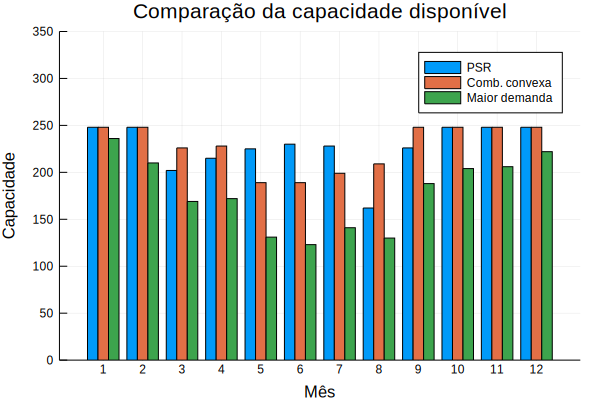

In [19]:
comp1and2 = comparison(dl, G, dados1, schedule_matrix1, dados2, schedule_matrix2; xlabel1 = "PSR", xlabel2 = "Comb. convexa", legend1 = true,
    expected_value_of_demand = false)
comp1and2[1]

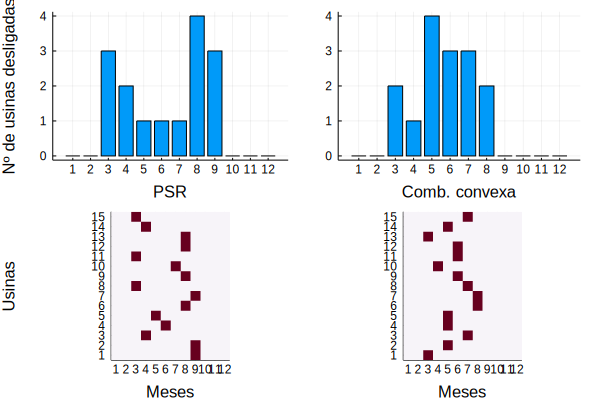

In [20]:
comp1and2[2]

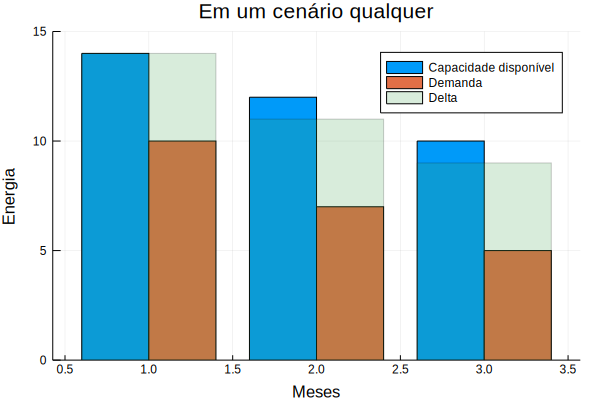

In [81]:
groupedbar([[14, 12, 10] [10, 7, 5]], label = ["Capacidade disponível", "Demanda"],
    xaxis = "Meses", yaxis = "Energia", ylims = (0, 15), title = "Em um cenário qualquer")
bar!([14, 11, 9], alpha = 0.2, label = "Delta")

## Dados reais da Colômbia

In [22]:
hydro3 = CSV.read("..\\..\\Files\\Caso_Real_Colombia\\Hydro_co.csv")
termica3 = CSV.read("..\\..\\Files\\Caso_Real_Colombia\\Termica_co.csv")
demanda3 = CSV.read("..\\..\\Files\\Caso_Real_Colombia\\Demanda_co.csv");

In [23]:
g_h3 = []
p4 = []
for line in 1:length(hydro3[:, 1])
    a = minimum([hydro3[4][line], hydro3.PotMax[line]])
    p = hydro3[11][line]
    if a != 0
        push!(g_h3, a)
        push!(p4, p)
    end
end
g_h3 = [g_h3; termica3[4]];
p4 = [p4; termica3[6]]
dl3 = demanda3[3]
for s in 4:length(demanda3[1, :])
    dl3 = hcat(dl3, demanda3[s])
end;

In [24]:
N_t3 = 12
N_S3 = 10
r3 = zeros(1, N_S3, N_t3)
dt3 = [maximum(dl3[month, :]) for month in 1:12]
d_s3 = dl3'
β3 = 0.2
λ3 = 0.0
k3 = 1;

In [25]:
m3 = Model(solver = Xpress.XpressSolver(OUTPUTLOG = 1, MIPRELSTOP = 0.04, MAXTIME = 3600))

@variables m3 begin
    α_h[1:length(g_h3), 1:N_t3], Bin
    δ_s[1:N_S3]
    z
    μ_s[1:N_S3] <= 0
end

@constraintref reserve[1:N_t3, 1:N_S3]
for t in 1:N_t3
    for s in 1:N_S3
        reserve[t, s] = @constraint(m3, δ_s[s]
            <= 1 / dt3[t] * (sum(g_h3[h] * (1 - α_h[h, t]) for h in 1:length(g_h3)) - d_s3[s, t]))
    end
end

@constraintref CVaR[1:N_S3]
for s in 1:N_S3
    CVaR[s] = @constraint(m3, μ_s[s] + z <= δ_s[s])
end

@constraintref plants_h[1:length(g_h3)]
for h in 1:length(g_h3)
    plants_h[h] = @constraint(m3, sum((1 - α_h[h, t]) for t in 1:N_t3) == N_t3 - k3)
end

@expression(m3, CVaR_β, z + 1 / N_S3 * 1 / (1 - β3) * sum(μ_s))

@objective(m3, Max, λ3 * CVaR_β + (1 - λ3) * 1 / N_S3 * sum(δ_s));

In [26]:
JuMP.build(m3)
Xpress.setlogfile(m3.internalModel.inner,"../../Files/Logs/Apresentacao das tarefas (2)/m3.log")

In [27]:
@time solve(m3)
δ_s3 = getvalue(δ_s)
schedule_matrix3 = getvalue(α_h);

  0.085375 seconds (90 allocations: 127.008 KiB)


In [28]:
dados3, heatmap3, graph3 = dados_e_plot(g_h3, schedule_matrix3, dl3, legend = true, y_max = 20000)
dados3

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[5, 8, 69]",14061.1
2,2,"[10, 31, 44, 61, 62]",14789.2
3,3,"[20, 32, 33, 58]",14130.2
4,4,"[9, 22, 29, 30, 36, 47, 56]",14046.6
5,5,"[19, 25, 64, 66]",14489.2
6,6,"[2, 14, 41, 55]",14186.5
7,7,"[15, 17, 28, 59]",14039.2
8,8,"[1, 3, 7, 35, 52, 70]",14627.3
9,9,"[4, 27, 38, 53, 57, 65]",14742.8


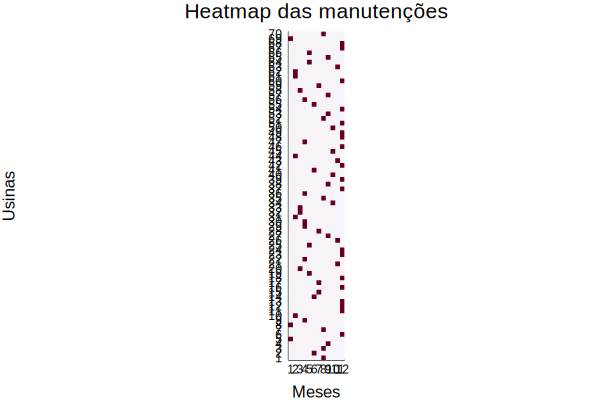

In [29]:
heatmap3

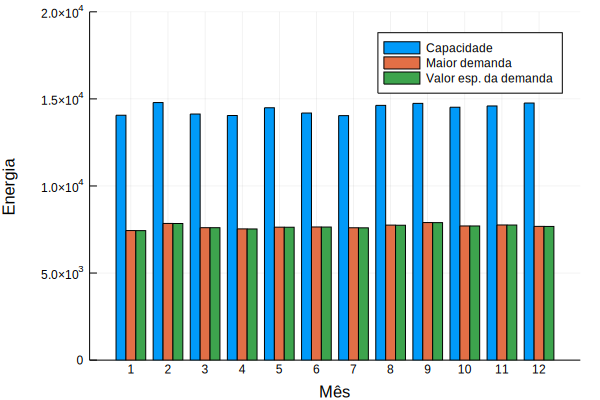

In [30]:
graph3

In [31]:
G4 = g_h3
d4 = dl3
θ4 = θ
λ4 = 0.0

Ns4 = Ns
nplants4 = length(G4)
nmonths4 = size(d4)[1];

In [32]:
m4 = Model(solver = Xpress.XpressSolver(OUTPUTLOG = 1, MIPRELSTOP = 0.04, MAXTIME = 3600))

@variable(m4, x[1:nplants4, 1:nmonths4], Bin)
@variable(m4, α[1:Ns4])
@variable(m4, z)
@variable(m4, δ[1:Ns4])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants4]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m4, sum(x[plant, 1:nmonths4]) == 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths4, 1:Ns4]
for month in 1:nmonths4
    for scenario in 1:Ns4
        constraints2[month, scenario] = @constraint(m4, sum(G4 .* (1 .- x[1:nplants4, month])) >= d4[month, scenario])
    end
end

@constraintref constraints3[1:nmonths4, 1:Ns4]
for month in 1:nmonths4
    for scenario in 1:Ns4
        constraints3[month, scenario] = @constraint(m4, α[scenario] >= sum(G4 .* (1 .- x[1:nplants4, month])) - d4[month, scenario])
    end
end

@constraintref constraints4[1:Ns4]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m4, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns4]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m4, δ[scenario] <= 0)
end

@expression(m4, CVaR, z - sum(1 / Ns4 * δ[scenario] / (1 - θ4) for scenario in 1:Ns4))
@expression(m4, Eα, sum(α) / Ns4)

@objective(m4, Min, λ4 * CVaR + (1 - λ4) * Eα);

In [33]:
JuMP.build(m4)
Xpress.setlogfile(m4.internalModel.inner,"../../Files/Logs/Apresentacao das tarefas (2)/m4.log")

In [34]:
@time solve(m4)
schedule_matrix4 = getvalue(x);

  0.125640 seconds (90 allocations: 138.398 KiB)


In [35]:
dados4, heatmap4, graph4 = dados_e_plot(G4, schedule_matrix4, d4, legend = true, y_max = 20000)
dados4

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,"[1, 23, 24, 29, 35, 36, 37, 38, 39, 40, 41, 47, 53, 54, 68]",14430.6
2,2,"[13, 17, 18, 19, 20, 62, 64]",14620.3
3,3,"[3, 31, 43, 46, 56, 57, 61, 67]",14407.2
4,4,"[6, 8, 21, 32, 45, 60]",14330.2
5,5,"[9, 27, 30, 34, 69]",14445.8
6,6,"[5, 10]",14180.2
7,7,"[15, 44, 49]",14218.2
8,8,"[22, 42, 52, 65]",14440.2
9,9,"[7, 14, 28, 33, 59]",14518.4


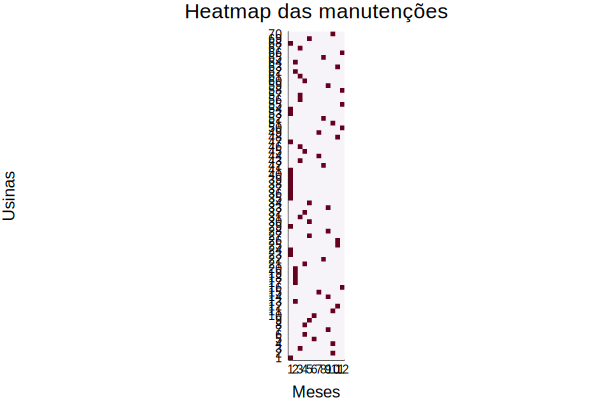

In [36]:
heatmap4

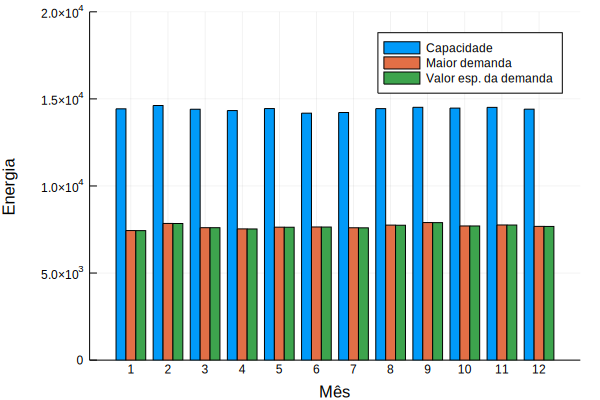

In [37]:
graph4

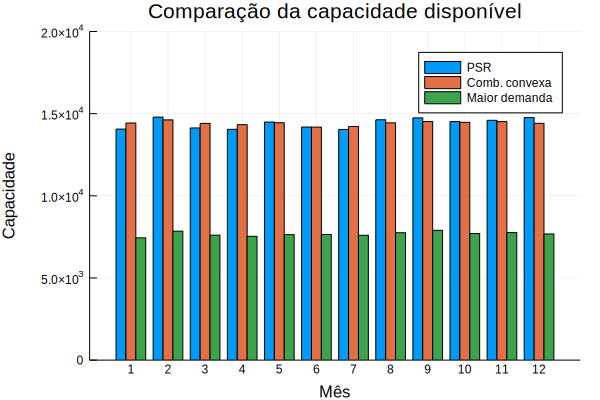

In [92]:
comp3and4 = comparison(dl3, g_h3, dados3, schedule_matrix3, dados4, schedule_matrix4; xlabel1 = "PSR", xlabel2 = "Comb. convexa", legend1 = true, expected_value_of_demand = false, y_max1 = 20000, heatmap2 = false)
comp3and4[1]

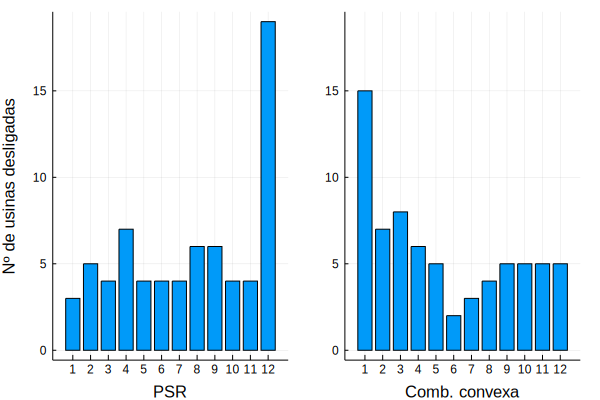

In [93]:
comp3and4[2]

# Probabilidade de falha

## Soma de variáveis aleatórias

Dadas duas variáveis independentes $X$ e $Y$ e suas probabilidades $f_X(x)$ e $f_Y(y)$, respectivamente, como calcular $f_Z(z)$ onde $Z = X + Y$?

Calculamos a probabilidade conjunta $f(x, y) = f_X(x)f_Y(y)$.

Seguimos com $F_Z(z) = P(Z \leq z) = P(X + Y \leq z) = \int\int_{R}f(x, y)dA$, com $R$ definida pela região $X + Y \leq z$. Temos, portanto, a probabilidade acumulada de $X + Y \leq z$.

Temos também $F_Z(z) = \int_{-\infty}^z f_Z(t)dt$. Deriva-se $F_Z(z)$ encontrado e tem-se $f_Z(z)$.

## Implementação para $2$ usinas

Uma implementação possível para duas usinas é calcular a priori as probabilidades para todos os casos de manutenção. 

$f_i$ é uma variável auxiliar que indica que a usina $i$ está em manutenção ($0$ corresponde à manutenção); $P_c$ é a probabilidade da demanda ser suprida em um dado cenário de manutenção; $P_j$ é a probabilidade da demanda ser suprida no cenário de manutenção $j$; $\gamma_j$ é uma variável auxiliar da convolução. Segue:

$$min\ \ G_{disp}$$

$$s.a.\ \ G_{disp} = \sum G_i f_i$$
$$P_c \geq \epsilon$$
$$P_c = \sum_{j = 0} P_j \gamma_j$$
$$\sum_{j = 0} \gamma_j = 1$$

$$\gamma_j \geq 0, \forall j$$
$$\gamma_0 \geq 1 - f_1 - f_2$$
$$\gamma_1 \geq f_1 - f_2$$
$$\gamma_2 \geq f_2 - f_1$$
$$\gamma_3 \geq f_1 + f_2 - 1$$

Sendo assim, como $\sum_{j = 0} \gamma_j = 1$, apenas um $\gamma_j$ será $1$, de modo que $P_c = \sum_{i = 0} P_i \gamma_i$ será igual a apenas um $P_j \gamma_j$. Ou seja, o solver escolhe aquele caso (ou um daqueles casos) em que $P_j \geq \epsilon$.

Sejam duas usinas com capacidades disponíveis $G_1 = 30$ e $G_2 = 40$ e uma demanda $D = 35$.

In [40]:
G5 = [30, 40]
D5 = 35
p5 = [0.5, 0.5]
ϵ5 = 0.3 #Probabilidade de falha de cada gerador
nplants5 = length(G5)
nmonths5 = size(D5);

In [41]:
fy1(y) = if (y == 0) p5[1] elseif (y==G5[1]) 1-p5[1] else 0 end;
fy2(y) = if (y == 0) p5[2] elseif (y==G5[2]) 1-p5[2] else 0 end;
fz(z) = sum(fy1(y)*fy2(z-y) for y = 0:z);
Fy1(D) = sum(fy1(y) for y=0:D-1);
Fy2(D) = sum(fy2(y) for y=0:D-1);
Fz(D) = sum(fz(z) for z = 0:D-1);

In [42]:
# Criando tabela de probabilidade:
P5 = [0.0000000]
push!(P5, 1-Fy1(D5))
push!(P5, 1-Fy2(D5))
push!(P5, 1-Fz(D5))

4-element Array{Float64,1}:
 0.0
 0.0
 0.5
 0.5

In [43]:
m5 = Model(solver = Xpress.XpressSolver())

@variable(m5, f[1:nplants5], Bin)
@variable(m5, γ[1:nplants5^2], Bin)
@variable(m5, G_disp)
@variable(m5, Pc)

@constraint(m5, G_disp == sum(G5 .* f))
@constraint(m5, Pc >= ϵ5)
@constraint(m5, Pc == sum(P5 .* γ))
@constraint(m5, sum(γ) == 1)

@constraint(m5, γ[1] >= 1 - f[1] - f[2])
@constraint(m5, γ[2] >= f[1] - f[2])
@constraint(m5, γ[3] >= f[2] - f[1])
@constraint(m5, γ[4] >= f[1] + f[2] - 1)

@objective(m5, Min, G_disp);

In [44]:
@time solve(m5)
@show getvalue(f)
@show getvalue(γ)
@show getvalue(G_disp)
@show getvalue(Pc);

  0.008508 seconds (162 allocations: 15.992 KiB)
getvalue(f) = [-0.0, 1.0]
getvalue(γ) = [-0.0, -0.0, 1.0, -0.0]
getvalue(G_disp) = 40.0
getvalue(Pc) = 0.5


## Implementação para $n$ usinas

Calcula-se a priori as probabilidades para todos os casos de manutenção. 

$f_i$ é uma variável auxiliar que indica que a usina $i$ está em manutenção ($0$ corresponde à manutenção); $P_c$ é a probabilidade da demanda ser suprida em um dado cenário de manutenção; $P_j$ é a probabilidade da demanda ser suprida no cenário de manutenção $j$; $\gamma_j$ é uma variável auxiliar para o cálculo. Segue:

$$min\ \ G_{disp}$$

$$s.a.\ \ G_{disp} = \sum G_i f_i$$
$$P_c \geq \epsilon$$
$$P_c = \sum_{j = 0} P_j \gamma_j$$
$$\sum_{j = 0} \gamma_j = 1$$

$$\gamma_j \geq 0, \forall j$$
$$\gamma_j \geq \sum_{k \in K_j} f_k - \sum_{m \in M_j} f_m - |K_j| + 1, \ \ \forall j$$

sendo $K_j$ o conjunto de usinas disponíveis no cenário de manutenção $j$, $M_j$ o conjunto de usinas em manutenção no cenário $j$ e $|K_j|$ o número de usinas disponíveis no cenário $j$.

In [45]:
G6 = G
D6 = 180
ϵ6 = 0.5
p6 = rand(0:3, 15) ./ 10
nplants6 = length(G6);

In [46]:
function prob(G, p, D)
    F_Z = 0
    nplants = length(G)
    for config in 0:(2^nplants - 1) #Para cada configuração de falha
        config_bin = Base.bin(Unsigned(config), nplants, false) #Converte para binário
        X = [parse(Int, config_bin[end - plant + 1]) for plant in 1:nplants] #Converte para array
        Z = sum(G .* X)            
        if Z < D
            F_Z += prod(X .+ (-1).^X .* p)
        end
    end
    return 1 - F_Z
end;

In [47]:
function tabela(G, p, D)
    nplants = length(G)
    tabela = zeros(2^nplants, 2)
    tabela = convert(Array{Any}, tabela)
    
    for config in 0:(2^nplants - 1)
        config_bin = Base.bin(Unsigned(config), nplants, false)
        X = [parse(Int, config_bin[end - plant + 1]) for plant in 1:nplants] #Converte para array
        Z = sum(G .* X)
        if Z >= D
            tabela[config + 1, 1] = config_bin
            G_aux = []
            p_aux = []
            for plant in 1:nplants
                if config_bin[end + 1 - plant] == '1'
                    push!(G_aux, G[plant])
                    push!(p_aux, p[plant])
                end
            end
            if length(G_aux) == 0 #Se o número de usinas é zero
                probability = 0.0
            else
                probability = prob(G_aux, p_aux, D)
            end
            tabela[config + 1, 2] = probability
        end
    end
    return tabela
end;     

In [48]:
@time tabela6 = tabela(G6, p6, D6);

 17.472770 seconds (239.64 M allocations: 7.107 GiB, 11.95% gc time)


In [49]:
m6 = Model(solver = Xpress.XpressSolver(OUTPUTLOG = 1))

@variable(m6, G_disp)
@variable(m6, f[1:nplants6], Bin)
@variable(m6, Pc)
@variable(m6, γ[1:2^nplants6], Bin)

@constraint(m6, G_disp == sum(G6 .* f))
@constraint(m6, Pc >= ϵ6)
@constraint(m6, Pc == sum(tabela6[:, 2] .* γ))
@constraint(m6, sum(γ) == 1)

for j in 0:(2^nplants6 - 1)
    j_bin = Base.bin(Unsigned(j), nplants6, false)
    j_array = [parse(Int, j_bin[end + 1 - plant]) for plant in 1:nplants6]
    @constraint(m6, γ[j + 1] >= sum((-1)^(1 + j_array[plant]) * f[plant] for plant in 1:nplants6) + 1 - count_ones(j))
end

@objective(m6, Min, G_disp);

In [50]:
JuMP.build(m6)
Xpress.setlogfile(m6.internalModel.inner,"../../Files/Logs/Apresentacao das tarefas (2)/m6.log")

In [51]:
@time solve(m6)
@show getvalue(f)
#@show getvalue(γ)
@show getvalue(G_disp)
@show getvalue(Pc);

140.613105 seconds (127 allocations: 6.542 MiB)
getvalue(f) = [1.0, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
getvalue(G_disp) = 211.0
getvalue(Pc) = 0.5222568960000007


## Método de Monte Carlo

O cálculo da probabilidade utilizando o Método de Monte Carlo consiste em simular repetidamente o processo aleatório de falha das usinas, utilizando suas probabilidades de falha, e verificar se a demanda é suprida em cada caso. A probabilidade da demanda ser suprida é aproximadamente a razão entre o número de casos em que a demanda foi suprida na simulação e o número total de casos.

In [52]:
G7 = G5
p7 = p5
D7 = D5;

In [53]:
function prob_MC(G, p, D, n)
    nplants = length(G)
    count = 0
    for i in 1:n
        Z = 0
        for plant in 1:nplants
            if rand() > p[plant]
                Z += G[plant]
            end
        end
        if Z >= D
            count += 1
        end
    end
    return count / n
end;

In [54]:
function tabela_MC(G, p, D; n = 1000)
    nplants = length(G)
    tabela = zeros(2^nplants, 2)
    tabela = convert(Array{Any}, tabela)
    
    for config in 0:(2^nplants - 1)
        config_bin = Base.bin(Unsigned(config), nplants, false)
        tabela[config + 1, 1] = config_bin
        G_aux = []
        p_aux = []
        for plant in 1:nplants
            if config_bin[end + 1 - plant] == '1'
                push!(G_aux, G[plant])
                push!(p_aux, p[plant])
            end
        end
        if length(G_aux) == 0 #Se o número de usinas é zero
            probability = 0.0
        else
            probability = prob_MC(G_aux, p_aux, D, n)
        end
        tabela[config + 1, 2] = probability
    end
    return tabela
end;     

In [55]:
tabela7 = tabela_MC(G7, p7, D7, n = 10000)

4×2 Array{Any,2}:
 "00"  0.0   
 "01"  0.0   
 "10"  0.5033
 "11"  0.5032

In [56]:
P5

4-element Array{Float64,1}:
 0.0
 0.0
 0.5
 0.5

In [57]:
G8 = G6
p8 = p6
D8 = D6;

In [58]:
@time tabela8 = tabela_MC(G8, p8, D8);

 13.392085 seconds (246.38 M allocations: 3.686 GiB, 8.82% gc time)


In [59]:
tabela6[(end - 10):end, :]

11×2 Array{Any,2}:
 "111111111110101"  0.646285
 "111111111110110"  0.571976
 "111111111110111"  0.711221
 "111111111111000"  0.455394
 "111111111111001"  0.57883 
 "111111111111010"  0.50144 
 "111111111111011"  0.637971
 "111111111111100"  0.691878
 "111111111111101"  0.796903
 "111111111111110"  0.742364
 "111111111111111"  0.843695

In [60]:
tabela8[(end - 10):end, :]

11×2 Array{Any,2}:
 "111111111110101"  0.637
 "111111111110110"  0.571
 "111111111110111"  0.723
 "111111111111000"  0.458
 "111111111111001"  0.592
 "111111111111010"  0.507
 "111111111111011"  0.652
 "111111111111100"  0.709
 "111111111111101"  0.808
 "111111111111110"  0.75 
 "111111111111111"  0.854

## Restrição de manutenção e vários estágios

Existem vários estágios, digamos, meses, e cada usina deve entrar em manutenção em um estágio. A probabilidade da demanda ser suprida deve ser maior do que ou igual a um parâmetro informado, para todo estágio. Maximiza-se a soma das probabilidades da demanda ser suprida nos estágios.

Calcula-se a priori as probabilidades para todos os casos de manutenção. 

$f_i^t$ é uma variável auxiliar que indica que a usina $i$ está em manutenção no estágio $t$ ($0$ corresponde à manutenção); $P_c^t$ é a probabilidade da demanda ser suprida em um dado cenário de manutenção no estágio $t$; $P_j^t$ é a probabilidade da demanda ser suprida no cenário de manutenção $j$, no estágio $t$; $\gamma_j^t$ é uma variável auxiliar para o cálculo. Segue:

$$max\ \ \sum_t P_c^t$$

$$s.a.\ \ P_c^t \geq \epsilon, \ \ \forall t$$
$$P_c^t = \sum_{j = 0} P_j \gamma_j^t, \ \ \forall t$$
$$\sum_{j = 0} \gamma_j^t = 1, \ \ \forall t$$
$$\sum_t f_i^t = |T| - 1, \ \ \forall i$$

$$\gamma_j^t \geq 0, \forall j, t$$
$$\gamma_j^t \geq \sum_{k \in K_j} f_k^t - \sum_{m \in M_j} f_m^t - |K_j| + 1, \ \ \forall j, t$$

sendo $T$ o conjunto de estágios, $|T|$ o número de estágios (exemplo, $12$ meses), $K_j$ o conjunto de usinas disponíveis no cenário de manutenção $j$, $M_j$ o conjunto de usinas em manutenção no cenário $j$ e $|K_j|$ o número de usinas disponíveis no cenário $j$.

In [61]:
G9 = G
d9 = d
ϵ9 = 0.7
nplants9 = length(G9)
N_t9 = length(d9)
p9 = rand(0:5, nplants9) ./ 100;

In [62]:
function tabelas(G, p, d)
    N_t = length(d)
    tabelas = []
    for t in 1:N_t
        D = d[t]
        push!(tabelas, tabela(G, p, D))
    end
    return tabelas
end;

In [63]:
@time tabelas9 = tabelas(G9, p9, d9);

210.003027 seconds (2.62 G allocations: 78.365 GiB, 12.51% gc time)


In [64]:
[maximum(tabelas9[month][:, 2]) for month in 1:12]

12-element Array{Float64,1}:
 0.7252361760219439
 0.9192232010232444
 0.9978995437603623
 0.9996078304787543
 0.9999991535878484
 0.9999997808928587
 0.999996205621984 
 0.9998937992317258
 0.9969212555134339
 0.9850984871475627
 0.9704493294981421
 0.7780316242946731

In [65]:
m9 = Model(solver = Xpress.XpressSolver(OUTPUTLOG = 1, MIPRELSTOP = 0.04, MAXTIME = 3600))

@variable(m9, f[1:nplants9, 1:N_t9], Bin)
@variable(m9, Pc[1:N_t9])
@variable(m9, γ[1:2^nplants9, 1:N_t9], Bin)

for t in 1:N_t9
    @constraint(m9, Pc[t] >= ϵ9)
    @constraint(m9, Pc[t] == sum(tabelas9[t][:, 2] .* γ[1:2^nplants9, t]))
    @constraint(m9, sum(γ[1:2^nplants9, t]) == 1)
end

for plant in 1:nplants9
    @constraint(m9, sum(f[plant, 1:N_t9]) == N_t9 - 1)
end
for t in 1:N_t9
    for j in 0:(2^nplants9 - 1)
        j_bin = Base.bin(Unsigned(j), nplants9, false)
        j_array = [parse(Int, j_bin[end + 1 - plant]) for plant in 1:nplants9]
        @constraint(m9, γ[j + 1, t] >= sum((-1)^(1 + j_array[plant]) * f[plant, t] for plant in 1:nplants9) + 1 - count_ones(j))
    end
end

@objective(m9, Max, sum(Pc));

In [66]:
JuMP.build(m9)
Xpress.setlogfile(m9.internalModel.inner,"../../Files/Logs/Apresentacao das tarefas (2)/m9.log")

In [67]:
@time solve(m9)
@show schedule_matrix9 = getvalue(f)
@show getvalue(Pc);

1684.507915 seconds (127 allocations: 78.408 MiB, 0.03% gc time)
schedule_matrix9 = getvalue(f) = [1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0; 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0; 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0; 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0]
getvalue(Pc) = [0.725236, 0.78274, 0.989558, 0.991884, 0.999985, 0.994707, 0.999753, 0.999476, 0.975437, 0.824853, 0.970449, 0.725236]


In [68]:
dados9, heatmap9, graph9 = dados_e_plot(G9, schedule_matrix9, d9, legend = true, inverse = true)
dados9

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],248.0
2,2,[13],236.0
3,3,[15],231.0
4,4,[12],216.0
5,5,"[7, 8]",229.0
6,6,"[4, 5, 6]",175.0
7,7,"[1, 3]",218.0
8,8,[14],235.0
9,9,[11],231.0


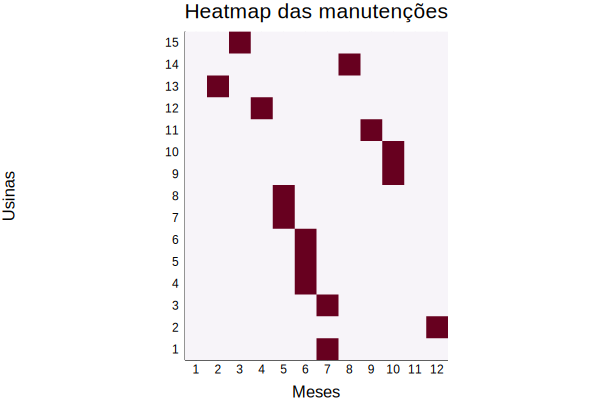

In [69]:
heatmap9

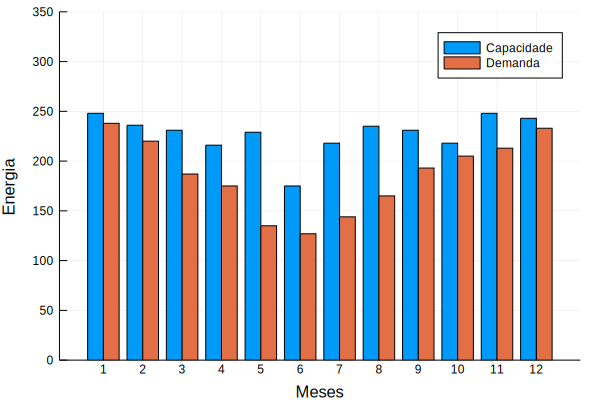

In [70]:
graph9

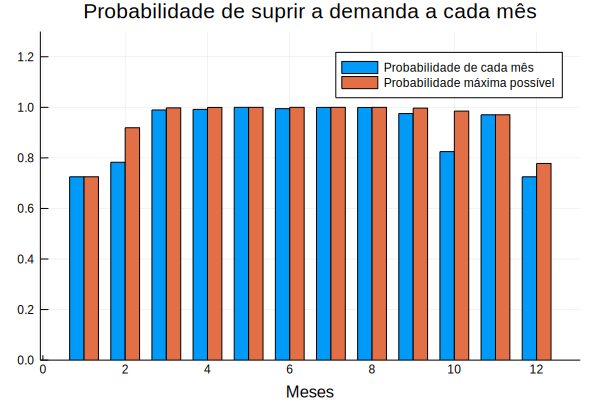

In [73]:
Pm = getvalue(Pc)
Pmax = [maximum(tabelas9[month][:, 2]) for month in 1:12]
ctg = repeat(["Probabilidade de cada mês", "Probabilidade máxima possível"], inner = 12)
groupedbar(hcat(Pm, Pmax), group = ctg, xlabel = "Meses", ylims = (0, 1.3),
        title = "Probabilidade de suprir a demanda a cada mês", bar_position = :dodge, bar_width=0.7)